# Прунинг и спарсификация сетей

На лекции мы обсуждали основы прунинга и спрарсификации нейронных сетей, а теперь попробуем самостоятельно реализовать некоторые подходы и посмотрим, какое влияние они оказывают на практике

# План семинара
1. Подготовка данных и базовый пайплайн обучения
2. Прунинг torch.nn.utils.prune
    1. Введение
    2. Вспомогательные функции
    3. Прунинг по магнитуде структурный и глобальный
    4. Честный структурный прунинг
3. Прунинг с Neural Network Intelligence
    1. Установка библиотеки
    2. Импорты
    3. Правила, чтобы ничего не ломалось

## Подготовка данных и базовый пайплайн обучения

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import torch.nn.utils.prune as prune


Прунинг — это удаление связей в нейронной сети с целью улучшения обобщения и сокращения вычислительных ресурсов.

Для начала создадим простую нейронную сеть и подготовим данные для нее.

image shape: torch.Size([256, 1, 28, 28]) 
 label shape: torch.Size([256])


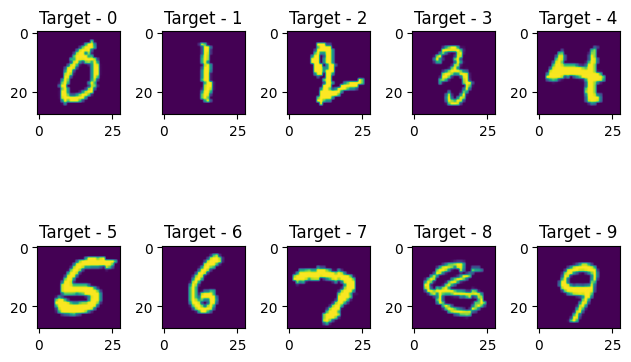

In [2]:
def load_MNIST():
    """Function to load and normalize MNIST data"""
    transform = transforms.Compose([
        transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

def visualize_MNIST(train_loader):
    """Function to visualize data given a DataLoader object"""
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    print("image shape:", images.shape, "\n label shape:", labels.shape)
    # visualize data
    fig, ax = plt.subplots(2,5)
    for i, ax in enumerate(ax.flatten()):
        im_idx = np.argwhere(labels == i)[0][0]
        plottable_image = images[im_idx].squeeze()
        ax.imshow(plottable_image)
        ax.set_title(f"Target - {i}")
    plt.tight_layout()

# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

In [3]:
def train_epoch(model, device, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in tqdm(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy


def evaluate(model, device, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_time = 0
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)
            start = time()
            outputs = model(data)
            total_time += time() - start
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    mean_time = total_time / len(dataloader)
    accuracy = 100 * correct / total
    return accuracy, mean_time


def full_train(
    model,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=10,
):
    metrics = defaultdict(list)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        train_loss, train_accuracy = train_epoch(
            model, device, train_loader, optimizer, criterion
        )
        test_accuracy, mean_time = evaluate(model, device, test_loader)
        metrics["train_loss"].append(train_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["mean_time"].append(mean_time)
        pbar.set_postfix_str(
            f"Epoch {epoch+1}, Train Loss: {round(train_loss, 4)}, "
            f"Train Acc: {round(train_accuracy, 4)}| "
            f"Test Acc: {round(test_accuracy, 4)}"
        )
    return pd.DataFrame(metrics)

В качестве модели будем использовать стандартную VGG архитектуру. Она довольно избыточна по параметрам, поэтому хорошо поддается спарсификации.

In [4]:
class VGG(nn.Module):
    def __init__(self, size=1):
        super().__init__()
        assert isinstance(size, int) and size > 0
        self.features = nn.Sequential(
            nn.Conv2d(1, 32 * size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32 * size, 64 * size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64 * size, 128 * size, kernel_size=3), # 128*size x 5 x 5
            nn.ReLU(),
            nn.Conv2d(128 * size, 128 * size, kernel_size=3, padding="same"), # 128*size x 5 x 5
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(2),
            nn.Flatten()
        )
        cl_size = 128
        self.classifier = nn.Sequential(
            nn.Linear(128 * size * 2 * 2, cl_size * size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(cl_size * size, cl_size * size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(cl_size * size, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
model = VGG(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:
result = full_train(
    model, device, train_loader, test_loader, optimizer, criterion, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
pretrained_model = deepcopy(model)

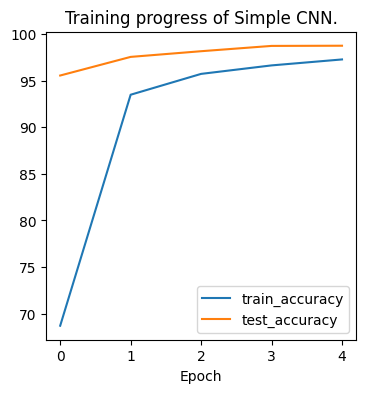

In [13]:
def plot_train_progress(df, title):
    plt.figure(figsize=(4,4))
    plt.title(f"Training progress of {title}.")
    plt.plot(df["train_accuracy"], label="train_accuracy")
    plt.plot(df["test_accuracy"], label="test_accuracy")
    plt.xlabel("Epoch")
    plt.legend()

plot_train_progress(result, "Simple CNN")

Почему качество на трейне меньше чем на тесте?

Визиализируем количество параметров на каждом слое:

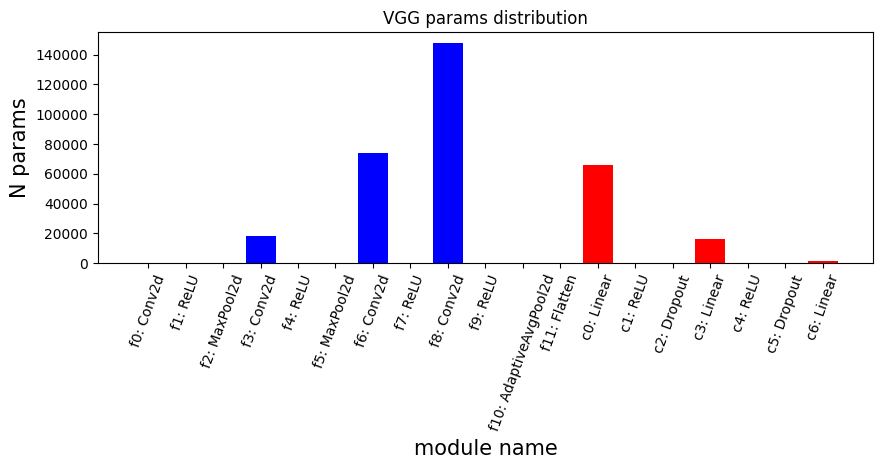

In [14]:
def show_param_numbers(model):
    plt.figure(figsize=(10, 3))
    x_labels = []
    y = []
    for i, module in enumerate(model.features):
        x_labels += [f"f{i}: {type(module).__name__}"]
        y += [sum(p.numel() for p in module.parameters() if p.requires_grad)]
    colors = ["blue"] * len(y)
    for i, module in enumerate(model.classifier):
        x_labels += [f"c{i}: {type(module).__name__}"]
        y += [sum(p.numel() for p in module.parameters() if p.requires_grad)]
    colors += ["red"] * (len(y) - len(colors))
    plt.bar(x_labels, y, color=colors)
    plt.xticks(rotation=70)
    plt.xlabel("module name", fontsize=15)
    plt.ylabel("N params", fontsize=15)
    plt.title("VGG params distribution")
show_param_numbers(VGG(1))

## Прунинг torch.nn.utils.prune

Сама по себе техника довольно простая и не очень новая, поэтому уже есть некоторые имплементации ее в самом торче.

Можно посмотреть самостоятельно гайд по использованию torch.nn.utils.prune здесь:
https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

### Ввведение

In [15]:
model = deepcopy(pretrained_model)

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): AdaptiveAvgPool2d(output_size=2)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [29]:
import torch.nn.utils.prune as prune
module = deepcopy(model.features[0])
# list(module.named_parameters())
list(module.named_parameters())[0][1].shape
# list(module.named_buffers())

torch.Size([32, 1, 3, 3])

In [30]:
prune.ln_structured(module, "weight", 0.2, 2, 0)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [31]:
# list(module.named_parameters())
# list(module.named_parameters())[0][1].shape
list(module.named_buffers())
# module.weight

[('weight_mask',
  tensor([[[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
           

In [32]:
prune.l1_unstructured(module, "weight", 0.2)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [33]:
list(module.named_buffers())

[('weight_mask',
  tensor([[[[0., 1., 1.],
            [1., 0., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 0.],
            [1., 1., 0.],
            [0., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[0., 1., 1.],
            [1., 1., 0.],
            [1., 0., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 0.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 0., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 1., 1.],
            [0., 0., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 1., 1.],
            [1., 1., 1.],
            [1., 1., 1.]]],
  
  
          [[[0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 0.]]],
  
  
          [[[1., 0., 1.],
            [1., 0., 1.],
            [1., 1., 1.]]],
  
  
          [[[1., 0., 1.],
           

In [34]:
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":  # select out the correct hook
        break

print(list(hook))

[<torch.nn.utils.prune.LnStructured object at 0x7f5878067340>, <torch.nn.utils.prune.L1Unstructured object at 0x7f5878067dc0>]


In [38]:
# list(module.named_parameters())
# prune.remove(module, 'weight')


### Вспомогательные функции

In [39]:
model.features[0].weight.shape

torch.Size([32, 1, 3, 3])

In [40]:
def iterative_pruning(model, pruning_method, train_loader, test_loader, device, num_iterations=10, save_models=False):
    # Initialize dictionary to store metrics
    metrics = defaultdict(list)

    # Calculate the initial total number of weights
    initial_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)
    remaining_rate = 1
    prune_rate = 1 / num_iterations
    print(f"Initial Prune_rate = {prune_rate}")

    # Record initial model performance
    initial_accuracy, _ = evaluate(model, device, test_loader)
    metrics['number_of_parameters'].append(initial_weights)
    metrics['accuracy'].append(initial_accuracy)
    metrics['accuracy_right_after_pruning'].append(initial_accuracy)
    models = []

    for iteration in range(num_iterations):
        # Calculate the effective pruning rate
        effective_pruning_rate = min(prune_rate / remaining_rate, 0.5)
        print(f"Effective pruning rate for iteration {iteration+1}: {effective_pruning_rate}")

        # Prune the model
        pruning_method(model, pruning_rate=effective_pruning_rate)
        post_prune_accuracy, _ = evaluate(model, device, test_loader)
        metrics['accuracy_right_after_pruning'].append(post_prune_accuracy)

        # Train for one epoch
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()
        train_epoch(model, device, train_loader, optimizer, criterion)

        # Evaluate the model
        accuracy, _ = evaluate(model, device, test_loader)

        # Update remaining rate and record metrics
        remaining_rate = (sum(mask.sum() for name, mask in model.named_buffers()) / initial_weights).item()
        if save_models:
            models += [deepcopy(model)]
        else:
            models = model
        metrics['number_of_parameters'].append(remaining_rate * initial_weights)
        metrics['accuracy'].append(accuracy)
        print(f"Iteration {iteration + 1}, Test Accuracy: {accuracy:.2f}%, Remaining Parameters: {remaining_rate * initial_weights}")

    return metrics, models

### Прунинг по магнитуде структурный и глобальный

In [41]:
def magnitude_global_pruning(model, pruning_rate):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_rate,
    )

def magnitude_local_pruning(model, pruning_rate):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            prune.l1_unstructured(module, name="weight", amount=pruning_rate)

def l2_structured_pruning(model, pruning_rate):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and name != "classifier.6":
            prune.ln_structured(module, name="weight", amount=pruning_rate, n=2, dim=0)
            if module.bias is not None:
                weight_mask = [mask for name, mask in module.named_buffers() if name == "weight_mask"][0]
                bias_mask = weight_mask.abs().sum(dim=tuple(range(1, len(weight_mask.shape)))) != 0
                prune.custom_from_mask(module, "bias", bias_mask)


def finalize_model_pruning(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and prune.is_pruned(module):
            prune.remove(module, 'weight')
            prune.remove(module, 'bias')


In [42]:
metrics, model = iterative_pruning(deepcopy(pretrained_model), magnitude_global_pruning, train_loader, test_loader, device, num_iterations=4)

Initial Prune_rate = 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

Effective pruning rate for iteration 1: 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 1, Test Accuracy: 99.16%, Remaining Parameters: 241368.00596928596
Effective pruning rate for iteration 2: 0.3352992028707334


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 2, Test Accuracy: 99.25%, Remaining Parameters: 160438.00764799118
Effective pruning rate for iteration 3: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 3, Test Accuracy: 99.17%, Remaining Parameters: 80219.00382399559
Effective pruning rate for iteration 4: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 4, Test Accuracy: 99.34%, Remaining Parameters: 40109.00023329258


In [43]:
all_results = {"magnitude_global_pruning": metrics}

[0.0, 25.439727306365967, 50.43957233428955, 75.21978616714478, 87.6100480556488]
[98.77, 99.16, 99.25, 99.17, 99.34]


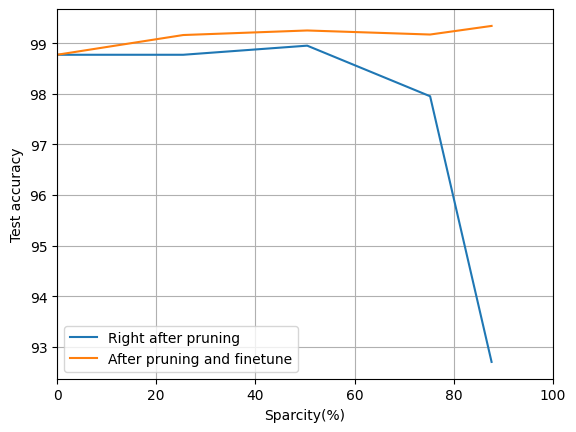

In [44]:
def plot_pruning_results(result):
    x = []
    y_before = []
    y_after = []
    for i in range(len(result["number_of_parameters"])):
        x += [100 - result["number_of_parameters"][i] / result["number_of_parameters"][0] * 100]
        y_before += [result["accuracy_right_after_pruning"][i]]
        y_after += [result["accuracy"][i]]
    plt.plot(x, y_before, label="Right after pruning")
    plt.plot(x, y_after, label="After pruning and finetune")
    plt.xlabel("Sparcity(%)")
    plt.ylabel("Test accuracy")
    plt.xlim(0, 100)
    plt.grid()
    plt.legend()
    print(x)
    print(y_after)

plot_pruning_results(all_results["magnitude_global_pruning"])

Качество даже улучшалось вплоть до уменьшения размера в 7 раз!

Теперь попробуем структурный прунинг. Ожидаем похуже качество

In [45]:
metrics, structured_models = iterative_pruning(deepcopy(pretrained_model), l2_structured_pruning, train_loader, test_loader, device, num_iterations=4, save_models=True)

Initial Prune_rate = 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

Effective pruning rate for iteration 1: 0.25


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 1, Test Accuracy: 98.96%, Remaining Parameters: 241824.012616992
Effective pruning rate for iteration 2: 0.33466693040190393


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 2, Test Accuracy: 98.98%, Remaining Parameters: 161216.00519543886
Effective pruning rate for iteration 3: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 3, Test Accuracy: 97.97%, Remaining Parameters: 80608.00259771943
Effective pruning rate for iteration 4: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 4, Test Accuracy: 93.56%, Remaining Parameters: 40304.001298859715


In [46]:
all_results["l2_structured_pruning"] = metrics

[0.0, 25.298863649368286, 50.19924342632294, 75.09962171316147, 87.54981085658073]
[98.77, 98.96, 98.98, 97.97, 93.56]


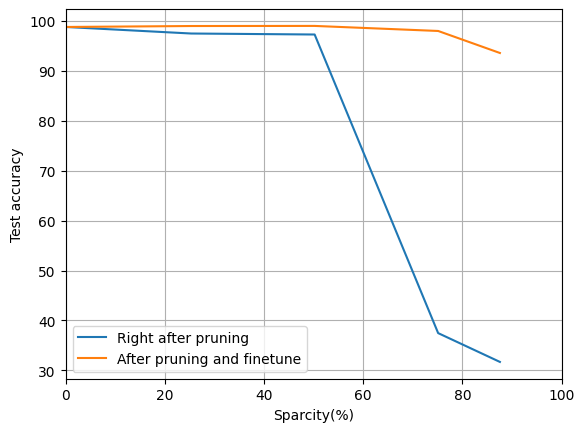

In [47]:
plot_pruning_results(all_results["l2_structured_pruning"])

Даже используя структурный прунинг мы смогли уменьшить размер в 4 раза с небольшими потерями!

### Честный структурный прунинг
Теперь реализуем настоящий честный структурный прунинг при помощи pytorch. Для этого просто удалим из модели нулевые ядра и нейроны. Возьмем модель на предпоследней итерации - которая в 4 раза меньше

In [48]:
structured_model = structured_models[-2]

In [49]:
def prune_vgg(model):
    new_layers = []
    prev_mask = None
    for layer in model.features + model.classifier:
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            dims = tuple(range(1, len(layer.weight.shape)))
            weight_sums = layer.weight.data.abs().sum(dim=dims)
            assert len(weight_sums.shape) == 1
            mask = weight_sums != 0
            if prev_mask is None:
                prev_mask = torch.ones(layer.weight.shape[1], dtype=torch.bool)
            if isinstance(layer, nn.Linear) and prev_mask.shape[0] < layer.weight.shape[1]:
                # that means we deal with first Linear layer after convolution
                prev_mask = prev_mask.repeat_interleave(layer.weight.shape[1] // prev_mask.shape[0])

            new_layer = (
                nn.Conv2d(
                    prev_mask.sum().item(),
                    mask.sum().item(),
                    layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                    bias=layer.bias is not None,
                )
                if isinstance(layer, nn.Conv2d)
                else nn.Linear(
                    prev_mask.sum().item(),
                    mask.sum().item(),
                    bias=layer.bias is not None,
                )
            )
            # print(f"Before: {layer}. After:{new_layer}")
            new_layer.weight.data = layer.weight.data[mask][:, prev_mask]
            new_layer.bias.data = layer.bias.data[mask]
            new_layers += [new_layer]
            prev_mask = mask
        else:
            new_layers += [layer]

    model.features = nn.Sequential(*(new_layers[:len(model.features)]))
    model.classifier = nn.Sequential(*(new_layers[len(model.features):]))
    return model

def eval_time(model, device="cuda"):
    model.eval()
    input_tensor = torch.randn((4096, 1, 28, 28), device=device)
    with torch.no_grad():
        start = time()
        for i in tqdm(range(1000)):
            model(input_tensor)
    return (time() - start) / 1000


real_structured_model = prune_vgg(deepcopy(structured_model))
real_structured_model = real_structured_model.to("cuda")

In [50]:
result = {
    "Structured_pruning(fake)": {
        "Eval accuracy": evaluate(structured_model, 'cuda', test_loader)[0],
        "Num parameters": sum(p.numel() for p in structured_model.parameters() if p.requires_grad),
        "Eval Time": eval_time(structured_model)
    }
}
result["Structured_pruning(real)"] = {
    "Eval accuracy": evaluate(real_structured_model, 'cuda', test_loader)[0],
    "Num parameters": sum(p.numel() for p in real_structured_model.parameters() if p.requires_grad),
    "Eval Time": eval_time(real_structured_model)
}
result = pd.DataFrame(result)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
result["ratio"] = result["Structured_pruning(fake)"] / result["Structured_pruning(real)"]
result

,Structured_pruning(fake),Structured_pruning(real),ratio
Eval accuracy,97.330000,97.330000,1.000000
Num parameters,323722.000000,20650.000000,15.676610
Eval Time,0.024055,0.003801,6.328739


В итоге получаем **чистую** оптимизацию: Меньше параметров в 15 раз и больше скорость в 6 раз.

Если вспоминать качество изначальной модели - 98.83, получили эти ускорения пожертвовав 1.5% качества. Если сделать шаги прунинга меньше, то можно получить лучший результат

Но подождите! Мы же брали модель, которая в 4 раза уменьшили на каждом слое. Почему после обрезки параметров стало меньше в 15 раз?

Все потому, что каждый раз удаляя выходной нейрон в одном слое, мы удаляем входной нейрон в следующем. Поэтому уменьшение возводится в квадрат. Давайте пересчитаем количество параметров более честно.

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[43.622614465498174, 74.82963777562229, 93.62106993037236, 98.36093932448212]
[98.96, 98.98, 97.97, 93.56]


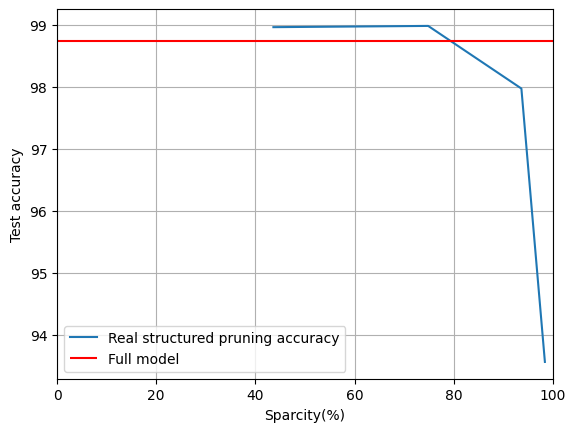

In [51]:
x = []
y_after = []
init_n_weight = sum(p.numel() for p in structured_models[0].parameters() if p.requires_grad)
for i in range(len(structured_models)):
    actual_model = prune_vgg(deepcopy(structured_models[i]))
    new_n = sum(p.numel() for p in actual_model.parameters() if p.requires_grad)
    x += [100 - new_n / init_n_weight * 100]
    y_after += [evaluate(actual_model, 'cuda', test_loader)[0]]
plt.plot(x, y_after, label="Real structured pruning accuracy")
plt.hlines(98.73, 0, 100, label="Full model", colors="r")
plt.xlabel("Sparcity(%)")
plt.ylabel("Test accuracy")
plt.xlim(0, 100)
plt.grid()
plt.legend()
print(x)
print(y_after)

Теперь выглядит более впечатляюще

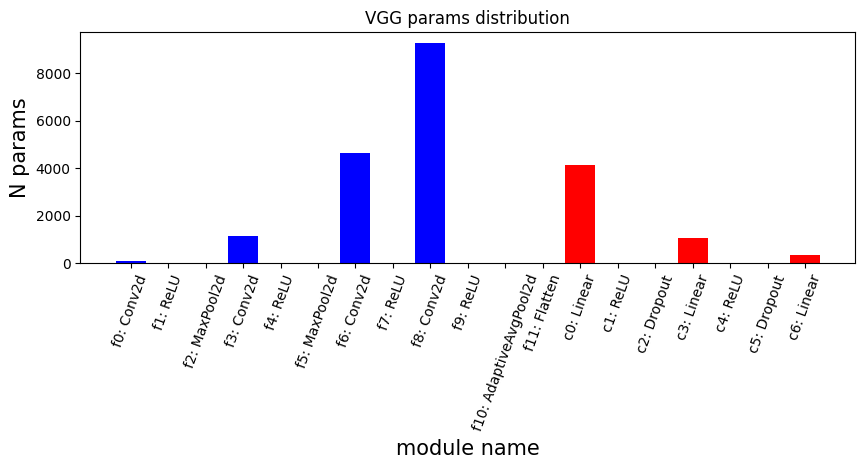

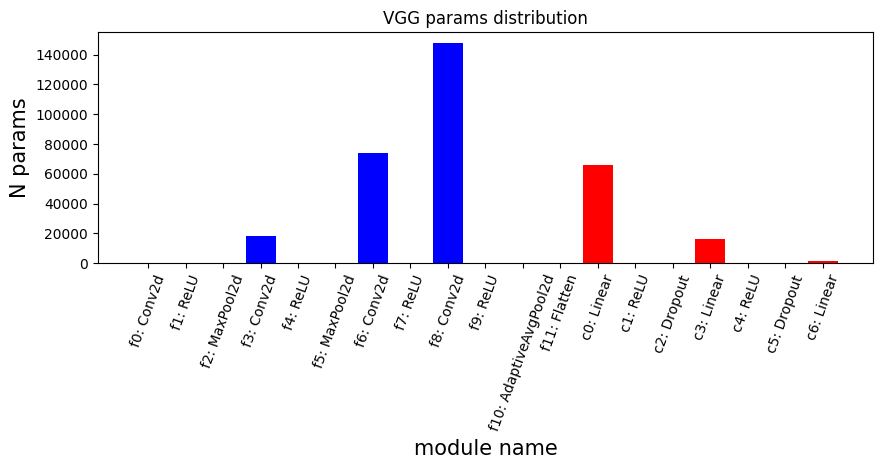

In [52]:
show_param_numbers(real_structured_model)
show_param_numbers(structured_model)

## Прунинг с Neural Network Intelligence

NNI предлагает качественную поддержку прунинга моделей.
https://nni.readthedocs.io/en/stable/tutorials/pruning_quick_start.html

### Установка библиотки
В колабе просто так оно не заработает, надо правильную версию торча

In [53]:
! pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
! pip install nni

Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 50.9 MB/s  0:00:40m0:00:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.0 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.1 MB/s  0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 54.2 MB/s  0:00:01 eta 0:00:01
  Attempting uninstall: torch━━━━━━━━━━━━━━━━━━━ 0/4 [triton]
    Found existing installation: torch 2.3.0a0+6ddf5cf85e.nv24.4riton]
    Uninstalling torch-2.3.0a0+6ddf5cf85e.nv24.4:━━━━━━━━━━━━━━━━━ 1/4 [torch]
      Successfully uninstalled torch-2.3.0a0+6ddf5cf85e.nv24.4━━━━ 1/4 [torch]
  Attempting uninstall: torchvision0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [torch]
    Found existing installation: torchvision 0.18.0a0━━━━━━━━━ 1/4 [torch]
    Uninstalling torchvision-0.18.0a0:━━━━━━━━━━━━━━━━━━━ 2/4 [torchvision]
      Successfully uninstalled torchvision-0.18.

### Импорты

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PIL import Image

from nni.compression.pruning import (
    L1NormPruner,
    L2NormPruner,
    FPGMPruner
)
from nni.compression.utils import auto_set_denpendency_group_ids
from nni.compression.speedup import ModelSpeedup

def get_num_params(module):
    return sum(p.numel() for p in module.parameters()) / 1000_000

def print_params_up_to_depth(module, max_depth=2, current_depth=0, name="Main"):
    if current_depth <= max_depth:
        print(f"{'  ' * current_depth}{name} {module.__class__.__name__}: {get_num_params(module)} parameters")
        if current_depth < max_depth:
            for subname, submodule in module.named_children():
                print_params_up_to_depth(submodule, max_depth, current_depth + 1, subname)

### Правила чтобы ничего не ломалось
1. Нельзя скип коннекшены между свертками и линейными слоями.
    - Скип между сверткой и сверткой это ок, но между сверткой и линейным библиотека не распознает
2. Нельзя иметь блоков в модели, которые не используются.
    - Если у модели прописан блок, через него должны проходить данные, иначе библиотека сломается
3. Нельзя возвращать None в выходах модулей. Только тензоры, словари тензоров, списки тензоров

In [ ]:
# ЭТА МОДЕЛЬ ВЗЯТА ИЗ ПОЗИТОРИЯ https://github.com/On-Point-RND/Efficient-AI-Models-2024
# ЭТА МОДЕЛЬ ВЗЯТА ИЗ ПОЗИТОРИЯ https://github.com/On-Point-RND/Efficient-AI-Models-2024
# ОНА ДЛЯ ДЕМОНСТРАЦИИ КРАЕВЫХ СЛУЧАЕВ, СКАЧИВАТЬ НЕ ОБЯЗАТЕЛЬНО

from cv_competition.MODNet.src.models.modnet import MODNet
from cv_competition.MODNet.inference.image_matting.inference_class import InfernceIMG

pretrained_ckpt = '../../cv_competition/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'
os.path.isfile(pretrained_ckpt)

weights = torch.load(pretrained_ckpt,  map_location=torch.device('cpu'))
model = MODNet(backbone_pretrained=False)
model.load_state_dict(weights)

# Правило 2
model.backbone = None
model.lr_branch.conv_lr = None
model.hr_branch.conv_hr = None
print_params_up_to_depth(model, 2)

In [ ]:
class SEBlock(nn.Module):
    """ SE Block with convolutional layers """

    def __init__(self, in_channels, out_channels, reduction=1):
        super(SEBlock, self).__init__()
        self.ff = nn.quantized.FloatFunctional()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, int(in_channels // reduction), kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(in_channels // reduction), out_channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x)
        w = self.fc(w)
        x = self.ff.mul(x, w.expand_as(x))
        return x

    @classmethod
    def from_original_se_block(cls, original_se_block):
        """ Convert an OriginalSEBlock to an SEBlock with convolutional layers """
        new_se_block = cls(
            in_channels=original_se_block.fc[0].in_features,
            out_channels=original_se_block.fc[2].out_features,
            reduction=original_se_block.fc[0].in_features // original_se_block.fc[0].out_features
        )

        # Transfer weights from linear layers to convolutional layers
        new_se_block.fc[0].weight.data = original_se_block.fc[0].weight.data.unsqueeze(-1).unsqueeze(-1)
        new_se_block.fc[2].weight.data = original_se_block.fc[2].weight.data.unsqueeze(-1).unsqueeze(-1)

        return new_se_block

# Правило 1
model.lr_branch.se_block = SEBlock.from_original_se_block(model.lr_branch.se_block)

In [ ]:
# https://nni.readthedocs.io/en/stable/compression/config_list.html

config_list = [{
        'op_types': ['Conv2d', "Linear"], # Список модулей, которые надо прунить
        'sparse_ratio': 0.25, # Уровень сжатия
        'exclude_op_names_re': ["f_branch.*"], # Исключение блока из прунинга (важно чтобы не получить резкого падения качества)
    }]
dummy_input = torch.zeros(10, 3, 512, 512) # Библиотека пропускает данные через модель и сама определяет блоки, которые можно прунить
config_list = auto_set_denpendency_group_ids(model, config_list, dummy_input) # Финальный конфиг создается автоматически

In [ ]:
config_list

[{'op_names': ['hr_branch.conv_hr4x.0.layers.0'],
  'sparse_ratio': 0.25,
  'global_group_id': 'model',
  'dependency_group_id': 'c7a447ae7fbf46af9cc2321f83fc2213',
  'internal_metric_block': 1},
 {'op_names': ['lr_branch.backbone.model.features.2.conv.3'],
  'sparse_ratio': 0.25,
  'global_group_id': 'model',
  'dependency_group_id': '837d64040d224c7da9d905a328af1b2f',
  'internal_metric_block': 1},
 {'op_names': ['lr_branch.backbone.model.features.16.conv.6'],
  'sparse_ratio': 0.25,
  'global_group_id': 'model',
  'dependency_group_id': '6bc7374bc4024567a5a0859f801759a5',
  'internal_metric_block': 1},
 {'op_names': ['lr_branch.backbone.model.features.17.conv.3'],
  'sparse_ratio': 0.25,
  'global_group_id': 'model',
  'dependency_group_id': '005e29e5b4e548dbb61f06b50ea63cde',
  'internal_metric_block': 1},
 {'op_names': ['hr_branch.tohr_enc2x.layers.0'],
  'sparse_ratio': 0.25,
  'global_group_id': 'model',
  'dependency_group_id': '1e29afbb185e43518cad511f78c92e34',
  'internal_me

In [ ]:
# Создаем прунер
pruner = L1NormPruner(model, config_list)

In [ ]:
# Применяем компрессию
compress, masks = pruner.compress()

In [ ]:
# Снимаем прунер с модели (раньше маски были отдельной сущностью, а теперь они применяться к весам и часть весов занулится)
pruner.unwrap_model()

In [ ]:
# Работает только для структурного прунинга.
# У модели удаляться фильтры в соответствии с масками.
# При этом библиотека сама позаботится о следующих за свертками BatchNorm и входными каналами следующих сверток.
# На выходе мы получим сжатую модель с физическим ускроением
model = ModelSpeedup(model, dummy_input, masks).speedup_model()

[2024-10-26 14:00:33] Start to speedup the model...
[2024-10-26 14:00:33] Resolve the mask conflict before mask propagate...
[2024-10-26 14:00:33] dim0 sparsity: 0.250000
[2024-10-26 14:00:33] dim1 sparsity: 0.000000
0 Filter
[2024-10-26 14:00:33] dim0 sparsity: 0.066549
[2024-10-26 14:00:33] dim1 sparsity: 0.000000
[2024-10-26 14:00:33] Infer module masks...
[2024-10-26 14:00:33] Propagate original variables
[2024-10-26 14:00:33] Propagate variables for placeholder: img, output mask:  0.0000 
[2024-10-26 14:00:33] Propagate variables for placeholder: inference, 
[2024-10-26 14:00:33] Propagate variables for call_module: lr_branch_backbone_model_features_0_0, weight:  0.0938 , output mask:  0.0000 
[2024-10-26 14:00:33] Propagate variables for call_module: lr_branch_backbone_model_features_0_1, , output mask:  0.0000 
[2024-10-26 14:00:33] Propagate variables for call_module: lr_branch_backbone_model_features_0_2, , output mask:  0.0000 
[2024-10-26 14:00:34] Propagate variables for ca

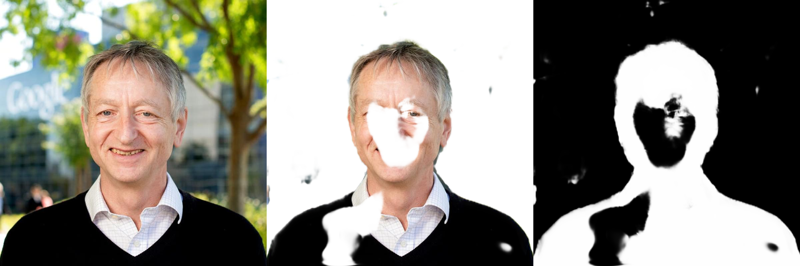

In [ ]:
inferer = InfernceIMG(device='cpu')
original_image = Image.open('data/input/hinton.jpg')

matte =  inferer.transform(model, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined

### Итеративный прунинг
На последок продемонстрирую на простом примере как запускать итеративный прунинг.

В начале сложно разобраться, но после того как весь пайплайн налажен, получается даже очень удобно.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
initial_model = VGG(1).to(device)
print_params_up_to_depth(initial_model)

Main VGG: 0.323722 parameters
  features Sequential: 0.240256 parameters
    0 Conv2d: 0.00032 parameters
    1 ReLU: 0.0 parameters
    2 MaxPool2d: 0.0 parameters
    3 Conv2d: 0.018496 parameters
    4 ReLU: 0.0 parameters
    5 MaxPool2d: 0.0 parameters
    6 Conv2d: 0.073856 parameters
    7 ReLU: 0.0 parameters
    8 Conv2d: 0.147584 parameters
    9 ReLU: 0.0 parameters
    10 AdaptiveAvgPool2d: 0.0 parameters
    11 Flatten: 0.0 parameters
  classifier Sequential: 0.083466 parameters
    0 Linear: 0.065664 parameters
    1 ReLU: 0.0 parameters
    2 Dropout: 0.0 parameters
    3 Linear: 0.016512 parameters
    4 ReLU: 0.0 parameters
    5 Dropout: 0.0 parameters
    6 Linear: 0.00129 parameters


In [9]:
from copy import deepcopy
import nni
import torchvision
import torchvision.transforms as transforms
from nni.compression import TorchEvaluator
from nni.compression.pruning import TaylorPruner, LinearPruner
from tqdm import tqdm

# This is for pruning
def training_step(batch, model):
    input_data, target = batch[0].to(device), batch[1].to(device)
    result = model(input_data)
    return loss(result, target)

def training_model(model, optimizer, training_step, lr_scheduler, max_steps, max_epochs):
    print("Train", max_epochs, max_steps)
    # max_steps, max_epochs might be None, which means unlimited training time,
    # so here we need set a default termination condition (by default, total_epochs=100, total_steps=10000).
    total_epochs = max_epochs if max_epochs else 100
    total_steps = max_steps if max_steps else 10000
    current_step = 0
    # init dataloader
    train_dataloader = trainloader
    for epoch in range(total_epochs):
        model.train()
        print("Test acc:", evaluate(model, testloader))
        for batch in tqdm(train_dataloader):
            if current_step % 100 == 0:
                print(scheduled_pruner.get_masks()["classifier.0"]["bias"].sum().item())
            optimizer.zero_grad()
            loss = training_step(batch, model)
            loss.backward()
            optimizer.step()
            current_step += 1
            if current_step >= total_steps:
                return

def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for inference
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Prepare loaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Prepare loss
loss = nn.CrossEntropyLoss()

In [10]:
n_steps, interval_steps, finetune_steps, final_sparsity = 10, 100, 500, 0.5
model = deepcopy(initial_model)
# Prepare optimizer
traced_optimizer = nni.trace(torch.optim.Adam)(model.parameters(), lr=1e-3)

evaluator = TorchEvaluator(training_model, traced_optimizer, training_step)

config_list = [{
    'op_types': ['Conv2d', 'Linear'],
    'sparse_ratio': final_sparsity,
    'exclude_op_names_re': ["classifier.6"],
}]
dummy_input = torch.rand(8, 1, 28, 28).to(device)
config_list = auto_set_denpendency_group_ids(model, config_list, dummy_input)

sub_pruner = TaylorPruner(model, config_list, evaluator, training_steps=interval_steps)
scheduled_pruner = LinearPruner(sub_pruner, interval_steps=interval_steps, total_times=n_steps)

_, masks = scheduled_pruner.compress(max_steps=n_steps * interval_steps + finetune_steps , max_epochs=None)
scheduled_pruner.unwrap_model()

model = ModelSpeedup(model, dummy_input, masks).speedup_model()
print('Pruned model paramater number: ', sum([param.numel() for param in model.parameters()]))
print('Pruned model acc: ', evaluate(model, testloader), '%')

Train None 1500
Test acc: 9.82


  0%|          | 0/938 [00:00<?, ?it/s]

128.0


 11%|█         | 105/938 [00:03<00:26, 31.15it/s]

122.0


 22%|██▏       | 205/938 [00:06<00:21, 34.25it/s]

116.0


 33%|███▎      | 305/938 [00:08<00:17, 36.53it/s]

109.0


 43%|████▎     | 405/938 [00:11<00:14, 36.05it/s]

103.0


 54%|█████▍    | 505/938 [00:14<00:12, 35.86it/s]

96.0


 64%|██████▍   | 605/938 [00:16<00:08, 37.21it/s]

90.0


 75%|███████▌  | 705/938 [00:19<00:06, 38.74it/s]

84.0


 86%|████████▌ | 807/938 [00:22<00:03, 38.28it/s]

77.0


 96%|█████████▋| 905/938 [00:24<00:00, 39.85it/s]

71.0


100%|██████████| 938/938 [00:25<00:00, 37.01it/s]


Test acc: 96.63


  7%|▋         | 70/938 [00:01<00:22, 38.72it/s]

64.0


 18%|█▊        | 169/938 [00:04<00:18, 40.95it/s]

64.0


 29%|██▊       | 268/938 [00:06<00:16, 41.22it/s]

64.0


 39%|███▉      | 367/938 [00:08<00:13, 42.30it/s]

64.0


 50%|████▉     | 467/938 [00:11<00:10, 43.05it/s]

64.0


 60%|█████▉    | 561/938 [00:13<00:09, 40.91it/s]


[2025-10-18 09:52:04] Start to speedup the model...
[2025-10-18 09:52:04] Resolve the mask conflict before mask propagate...
[2025-10-18 09:52:04] dim0 sparsity: 0.500000
[2025-10-18 09:52:04] dim1 sparsity: 0.000000
0 Filter
[2025-10-18 09:52:04] dim0 sparsity: 0.500000
[2025-10-18 09:52:04] dim1 sparsity: 0.000000
[2025-10-18 09:52:04] Infer module masks...
[2025-10-18 09:52:05] Propagate original variables
[2025-10-18 09:52:05] Propagate variables for placeholder: x, output mask:  0.0000 
[2025-10-18 09:52:05] Propagate variables for call_module: features_0, weight:  0.5000 bias:  0.5000 , output mask:  0.0000 
[2025-10-18 09:52:05] Propagate variables for call_module: features_1, , output mask:  0.0000 
[2025-10-18 09:52:05] Propagate variables for call_module: features_2, , output mask:  0.0000 
[2025-10-18 09:52:05] Propagate variables for call_module: features_3, weight:  0.5000 bias:  0.5000 , output mask:  0.0000 
[2025-10-18 09:52:05] Propagate variables for call_module: feat